In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
import random
import math
import matplotlib.pyplot as plt
import dendropy
import csv
from dendropy.calculate import treecompare
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


# Loading Data

In [2]:
whole_data = np.load('../../Data_Preprocessing/output/5000_Dataset/training_data.npy')
whole_labels_cub = np.load('../../Data_Preprocessing/output/5000_Dataset/training_dists_cub.npy')
whole_labels_flatten = np.load('../../Data_Preprocessing/output/5000_Dataset/training_dists_flatten.npy')

In [3]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

OUTPUT_DIST_NUM = int((BRANCH_NUM - 1) * BRANCH_NUM / 2)

In [4]:
print(whole_data.shape)
print(whole_labels_cub.shape)
print(whole_labels_flatten.shape)

(5174, 100, 1000, 1)
(5174, 100, 100, 1)
(5174, 4950)


### Plot before shuffle

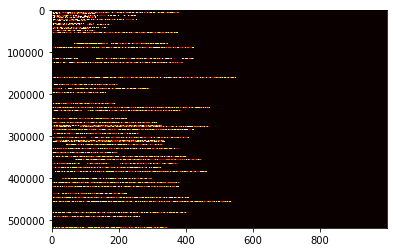

In [5]:
whole_data_before_shuffle = whole_data.reshape((whole_data.shape[0]*100, 1000))
plt.imshow(whole_data_before_shuffle, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

## Shuffle each input sampe (dim: 100 * 1000)

#### Use the same index for all input sample

In [6]:
shuffle_indices_100 = random.sample(range(0, 100), 100)
shuffle_indices_1000 = random.sample(range(0, 1000), 1000)

In [7]:
for i in range(whole_data.shape[0]):
    tmp = whole_data[i][shuffle_indices_100]
    tmp = tmp[:, shuffle_indices_1000]
    whole_data[i] = tmp

### Plot after shuffle

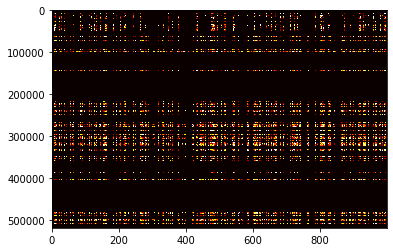

In [8]:
whole_data_after_shuffle = whole_data.reshape((whole_data.shape[0]*100, 1000))
plt.imshow(whole_data_after_shuffle, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

# Training Testing Dataset Partition

In [9]:
samples_count = whole_data.shape[0]

train_size = math.floor(0.85*whole_data.shape[0])

shuffle_indices = random.sample(range(0, samples_count), samples_count)

print(len(np.unique(shuffle_indices)))

5174


In [10]:
indices_train = shuffle_indices[0:train_size]
indices_test = shuffle_indices[train_size:samples_count]

In [24]:
print("######## Training Data ########")
X_train = whole_data[indices_train,:]
Y_train_cub = whole_labels_cub[indices_train]
Y_train_flatten = whole_labels_flatten[indices_train]

print("######## Validation Data ########")
X_test = whole_data[indices_test,:]
Y_test_cub = whole_labels_cub[indices_test]
Y_test_flatten = whole_labels_flatten[indices_test]

print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', Y_train_cub.shape)

print('Y_train_cub.shape : ', Y_train_cub.shape)
print('Y_test_cub.shape : ', Y_test_cub.shape)
print('Y_train_flatten.shape : ', Y_train_flatten.shape)
print('Y_test_flatten.shape : ', Y_test_flatten.shape)# Training Testing Dataset Partition

######## Training Data ########


KeyboardInterrupt: 

### Plot for shuffled X_train (samples)

In [12]:
X_train_shuffle = X_train.reshape((X_train.shape[0]*100, 1000))

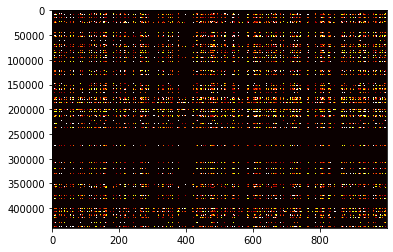

In [14]:
plt.imshow(X_train_shuffle, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Plot for shuffled X_test (samples)

In [15]:
X_test_shuffle = X_test.reshape((X_test.shape[0]*100, 1000))

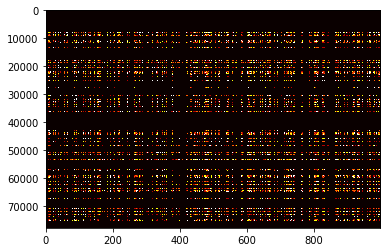

In [16]:
plt.imshow(X_test_shuffle, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

In [17]:
np.save('./output/X_train.npy', X_train)
np.save('./output/Y_train_cub.npy', Y_train_cub)
np.save('./output/Y_train_flatten.npy', Y_train_flatten)

np.save('./output/X_test.npy', X_test)
np.save('./output/Y_test_cub.npy', Y_test_cub)
np.save('./output/Y_test_flatten.npy', Y_test_flatten)

### Load Data

In [25]:
X_train = np.load('./output/X_train.npy')
Y_train_cub = np.load('./output/Y_train_cub.npy')
Y_train_flatten = np.load('./output/Y_train_flatten.npy')

X_test = np.load('./output/X_test.npy')
Y_test_cub = np.load('./output/Y_test_cub.npy')
Y_test_flatten = np.load('./output/Y_test_flatten.npy')

In [19]:
# model = Sequential()

# # Layer 1
# model.add(Conv2D(64, input_shape=X_train.shape[1:], kernel_size=(3,3), strides=(1,1), padding='same'))
# #model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 2
# model.add(Conv2D(32, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 3
# model.add(Conv2D(16, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 4
# model.add(Conv2D(1, (2, 1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(1, 2)))


In [28]:
model = Sequential()

# Layer 1
model.add(Conv2D(100, input_shape=X_train.shape[1:], kernel_size=(100,1), strides=(1,1)))
#model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 2
model.add(Conv2D(10, (1, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 3
model.add(Conv2D(5, (1, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 4
model.add(Conv2D(1, (1, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 5
model.add(Flatten())
model.add(Dense(OUTPUT_DIST_NUM, activation='relu'))

In [29]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 1000, 100)      10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1000, 100)      400       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1000, 100)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1000, 100)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 999, 10)        2010      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 999, 10)        40        
_________________________________________________________________
activation_2 (Activation)    (None, 1, 999, 10)       

In [30]:
# def log_loss:
#     if not K.is_tensor(y_pred):
#         y_pred = K.constant(y_pred)
#     y_true = K.cast(y_true, y_pred.dtype)
    
#     return K.log(K.square(y_pred - y_true), axis=-1)

In [31]:
# (4) Compile 
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['accuracy'])

In [32]:
loss_list_epoch= []
RF_avg_distance_epoch = []
RF_list_distance_epoch = []

In [34]:
## This function is defined for vector -> symmetric distance matrix
def utri2mat(utri):
    n = (int(-1 + np.sqrt(1 + 8*len(utri))) // 2) + 1
    iu1 = np.triu_indices(n-1)
    iu1 = (iu1[0], iu1[1] + 1)
    ret = np.zeros((n, n))
    ret[iu1] = utri
    ret.T[iu1] = utri
    return ret

In [36]:
# Do first time to initial the tree!
print("******** Start fitting model ********")
history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=50, epochs=1, verbose=1)
print(history.history['loss'])
loss_list_epoch.append(history.history['loss'][0])

print("******** Start calculating RF Distance ********")
RF_list_distance = []
for index in range(len(X_train)):
    tips_num = np.count_nonzero(np.sum(X_train[index], axis=1) != 0) 
#         print("tips_num: ", tips_num)
    array_selection_length = int((tips_num + 1) * tips_num / 2)
    Y_train_flatten_vec_sel = Y_train_flatten[index][0:array_selection_length]
    X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 1)))
    X_train_results_vec_sel = X_train_results[0][0:array_selection_length]
    original_dis_matrix = utri2mat(Y_train_flatten_vec_sel)
    new_dis_matrix = utri2mat(X_train_results_vec_sel)
    for i in range(len(new_dis_matrix)):
        new_dis_matrix[i,i] = 0
    with open('./output/CSV/original_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(original_dis_matrix)
    with open('./output/CSV/new_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(new_dis_matrix)
    taxon_namespace = dendropy.TaxonSet()
    pdm_origin = dendropy.PhylogeneticDistanceMatrix.from_csv(
            src=open('./output/CSV/original_dis_matrix'+str(index)+'.csv'),
            is_first_row_column_names=False,
            is_first_column_row_names=False,
            delimiter=",",
            taxon_namespace = taxon_namespace)
    pdm_new = dendropy.PhylogeneticDistanceMatrix.from_csv(
            src=open('./output/CSV/new_dis_matrix'+str(index)+'.csv'),
            is_first_row_column_names=False,
            is_first_column_row_names=False,
            delimiter=",",
            taxon_namespace = taxon_namespace)
    tree_origin = pdm_origin.nj_tree()
    tree_new = pdm_new.nj_tree()
    RF_distance = treecompare.symmetric_difference(tree_origin, tree_new)
    RF_list_distance.append(RF_distance)
RF_list_distance_epoch.append(RF_list_distance)
RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
print("RF_list_distance: ", RF_list_distance)
print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

******** Start fitting model ********
Train on 4397 samples, validate on 777 samples
Epoch 1/1
4397/4397 [==============================] - 12s 3ms/step - loss: 0.0098 - accuracy: 0.0168 - val_loss: 0.0084 - val_accuracy: 0.0039
[0.009762576711726813]
******** Start calculating RF Distance ********


/home/howard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'TaxonSet' will no longer be supported in future releases; use 'TaxonNamespace' instead


RF_list_distance:  [42, 32, 30, 32, 16, 32, 32, 32, 16, 132, 32, 16, 32, 62, 62, 32, 120, 60, 40, 16, 16, 46, 110, 138, 56, 62, 62, 60, 56, 26, 60, 74, 32, 60, 60, 16, 42, 58, 38, 14, 32, 16, 32, 32, 60, 54, 46, 34, 16, 32, 46, 16, 32, 32, 110, 30, 32, 60, 16, 32, 40, 54, 62, 38, 110, 32, 56, 48, 46, 58, 144, 16, 32, 40, 60, 32, 32, 32, 16, 32, 16, 32, 16, 26, 16, 32, 108, 44, 32, 60, 32, 50, 32, 136, 32, 120, 16, 112, 46, 32, 32, 16, 42, 134, 52, 40, 48, 16, 16, 14, 16, 14, 14, 134, 44, 54, 32, 60, 114, 16, 32, 42, 52, 52, 16, 32, 14, 40, 16, 32, 142, 32, 16, 98, 118, 32, 50, 32, 32, 32, 38, 56, 32, 16, 32, 32, 16, 48, 32, 62, 118, 58, 62, 14, 32, 60, 32, 32, 56, 62, 16, 52, 122, 60, 56, 14, 58, 16, 48, 16, 46, 32, 16, 32, 36, 32, 60, 30, 62, 124, 58, 32, 38, 16, 16, 116, 16, 32, 16, 32, 32, 36, 48, 32, 46, 32, 116, 56, 52, 16, 16, 32, 16, 42, 32, 48, 62, 32, 42, 16, 40, 42, 56, 32, 32, 32, 16, 16, 16, 16, 32, 54, 30, 30, 40, 32, 16, 16, 96, 32, 40, 16, 32, 40, 32, 32, 16, 36, 60, 32,

In [ ]:
# (5) Train
# history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=16, epochs=10, verbose=1)
for i in range(2):
    print("******** Start fitting model ********")
    history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=2, epochs=50, verbose=1)
    print(history.history['loss'])
    loss_list_epoch.append(history.history['loss'][0])

    print("******** Start calculating RF Distance ********")
    RF_list_distance = []
#     for index in range(len(X_train)):
#         tips_num = np.count_nonzero(np.sum(X_train[index], axis=1) != 0) 
# #         print("tips_num: ", tips_num)
#         array_selection_length = int((tips_num + 1) * tips_num / 2)
#         Y_train_flatten_vec_sel = Y_train_flatten[index][0:array_selection_length]
#         X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 1)))
#         X_train_results_vec_sel = X_train_results[0][0:array_selection_length]
#         original_dis_matrix = utri2mat(Y_train_flatten_vec_sel)
#         new_dis_matrix = utri2mat(X_train_results_vec_sel)
#         for i in range(len(new_dis_matrix)):
#             new_dis_matrix[i,i] = 0
#         with open('./output/CSV/original_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
#             csvWriter = csv.writer(my_csv,delimiter=',')
#             csvWriter.writerows(original_dis_matrix)
#         with open('./output/CSV/new_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
#             csvWriter = csv.writer(my_csv,delimiter=',')
#             csvWriter.writerows(new_dis_matrix)
#         taxon_namespace = dendropy.TaxonSet()
#         pdm_origin = dendropy.PhylogeneticDistanceMatrix.from_csv(
#                 src=open('./output/CSV/original_dis_matrix'+str(index)+'.csv'),
#                 is_first_row_column_names=False,
#                 is_first_column_row_names=False,
#                 delimiter=",",
#                 taxon_namespace = taxon_namespace)
#         pdm_new = dendropy.PhylogeneticDistanceMatrix.from_csv(
#                 src=open('./output/CSV/new_dis_matrix'+str(index)+'.csv'),
#                 is_first_row_column_names=False,
#                 is_first_column_row_names=False,
#                 delimiter=",",
#                 taxon_namespace = taxon_namespace)
#         tree_origin = pdm_origin.nj_tree()
#         tree_new = pdm_new.nj_tree()
#         RF_distance = treecompare.symmetric_difference(tree_origin, tree_new)
#         RF_list_distance.append(RF_distance)
#     RF_list_distance_epoch.append(RF_list_distance)
#     RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
#     print("RF_list_distance: ", RF_list_distance)
#     print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

In [ ]:
model.save('./output/CNN_model_03.h5')

In [ ]:
train_result = model.evaluate(X_train, Y_train_flatten)
test_result = model.evaluate(X_test, Y_test_flatten)
print("Train Acc: ", train_result)
print("Test Acc: ", test_result)

## Load the Model

In [ ]:
# model = keras.models.load_model('./output/CNN_model_03.h5')

## X_train plot

In [ ]:
X_train_results = model.predict(X_train)

In [ ]:
train_show_index = 0

In [ ]:
plt.scatter(range(X_train_results[train_show_index].shape[0]), X_train_results[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train_flatten[train_show_index].shape[0]), Y_train_flatten[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

In [ ]:
plt.scatter(X_train_results[train_show_index], Y_train_flatten[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [ ]:
X_train_results_resh= X_train_results.reshape((1, 425*OUTPUT_DIST_NUM))
Y_train_resh = Y_train_flatten.reshape((1, 425*OUTPUT_DIST_NUM))

In [ ]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_test plot

In [ ]:
X_test_results = model.predict(X_test)

In [ ]:
test_show_index = 10

In [ ]:
plt.scatter(range(X_test_results[test_show_index].shape[0]), X_test_results[test_show_index], c='r', s = 2)
plt.scatter(range(Y_test_flatten[test_show_index].shape[0]), Y_test_flatten[test_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

In [ ]:
plt.scatter(X_test_results[train_show_index], Y_test_flatten[train_show_index], c='r', s = 2)
plt.xlabel ('Validation Data Prediction')
plt.ylabel ('Validation Data Label')
plt.show

In [ ]:
X_test_results_resh= X_test_results.reshape((1, 75*OUTPUT_DIST_NUM))
Y_test_resh = Y_test_flatten.reshape((1, 75*OUTPUT_DIST_NUM))

In [ ]:
plt.scatter(X_test_results_resh, Y_test_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## Plot Loss 

In [ ]:
plt.plot(loss_list_epoch)
plt.show()

This is the loss plot for this model. I accidentally rerun the above cell and the output is erased, so I just put the result plot here.

![](https://i.imgur.com/4rqHApM.png)

## Plot RF distance

In [ ]:
for index in range(15):
    index_RF_dist = [each[index] for each in RF_list_distance_epoch]
    plt.plot(index_RF_dist)
    plt.xlabel ('Epochs Index')
    plt.ylabel ('RFR Distance')
    plt.show()

In [ ]:
plt.plot(RF_avg_distance_epoch)
plt.xlabel ('Epochs Index')
plt.ylabel ('RFR Distance')
plt.show()